In [1]:
!pip install -q -U 'tensorflow-text==2.8.*'

     |████████████████████████████████| 4.9 MB 14.1 MB/s 
     |████████████████████████████████| 498.0 MB 12 kB/s 
     |████████████████████████████████| 462 kB 79.1 MB/s 
     |████████████████████████████████| 1.4 MB 60.7 MB/s 
     |████████████████████████████████| 5.8 MB 49.0 MB/s 


In [2]:
!pip install -q tf-models-official

     |████████████████████████████████| 2.3 MB 14.3 MB/s 
     |████████████████████████████████| 662 kB 51.6 MB/s 
     |████████████████████████████████| 43 kB 2.2 MB/s 
     |████████████████████████████████| 118 kB 74.0 MB/s 
     |████████████████████████████████| 38.2 MB 200 kB/s 
     |████████████████████████████████| 1.1 MB 70.6 MB/s 
     |████████████████████████████████| 352 kB 65.4 MB/s 
     |████████████████████████████████| 238 kB 60.8 MB/s 
     |████████████████████████████████| 588.3 MB 21 kB/s 
     |████████████████████████████████| 1.3 MB 60.9 MB/s 
     |████████████████████████████████| 5.8 MB 58.1 MB/s 
     |████████████████████████████████| 1.7 MB 51.3 MB/s 
     |████████████████████████████████| 439 kB 76.2 MB/s 
     |████████████████████████████████| 6.0 MB 62.1 MB/s 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import re
import time
import unicodedata
import datetime
import pathlib

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras import layers

import tensorflow_hub as hub
import tensorflow_models as tfm

import tensorflow_text as text
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab

/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.8.0 and strictly below 2.11.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.11.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [5]:
tf.get_logger().setLevel('ERROR')
tf.config.run_functions_eagerly(True)

In [6]:
bert_model_name = 'bert_en_uncased_L-12_H-768_A-12'  
tfhub_handle_encoder =  'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
gs_folder_bert = 'gs://cloud-tpu-checkpoints/bert/v3/uncased_L-12_H-768_A-12'
bert_vocab = os.path.join(gs_folder_bert, 'vocab.txt')

print('BERT model selected                : ', tfhub_handle_encoder)
print('Preprocessing model auto-selected  : ', tfhub_handle_preprocess)
print('BERT vocab                         : ', bert_vocab)

BERT model selected                :  https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Preprocessing model auto-selected  :  https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3
BERT vocab                         :  gs://cloud-tpu-checkpoints/bert/v3/uncased_L-12_H-768_A-12/vocab.txt


### Variabili Globali

In [43]:
# PARAMETRI GLOBALI
root_folder = 'drive/MyDrive/BERT/'

# DATI
data_folder_name = 'data'
train_filename = 'ita.txt'

DATA_PATH = os.path.abspath(os.path.join(root_folder, data_folder_name))
train_filenamepath = os.path.abspath(os.path.join(DATA_PATH, train_filename))

# PATH LOG Tensorboard
PATH_LOG = 'logs/fit/transformer_bert'
PATH_LOG = os.path.abspath(os.path.join(root_folder, PATH_LOG))
log_dir =  os.path.abspath(os.path.join(PATH_LOG, datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))) 

# PATH WEIGHTS Tensorboard
PATH_WEIGHTS = 'weights/transformer_bert'
PATH_WEIGHTS = os.path.abspath(os.path.join(root_folder, PATH_WEIGHTS))
checkpoint_path = os.path.abspath(os.path.join(PATH_WEIGHTS, 'cp.ckpt'))
weights = os.path.abspath(os.path.join(PATH_WEIGHTS, 'weights_30_epochs.h5'))
model_weights = os.path.abspath(os.path.join(PATH_WEIGHTS, 'model_weights_30_epochs.h5'))

# MODELLO TOKENIZER
model_name = 'tokenizer_en_it_model'
tokenizer_folder_name = 'tokenizer'

TOKEN_PATH = os.path.abspath(os.path.join(root_folder, tokenizer_folder_name))
tokenizer_filenamepath = os.path.abspath(os.path.join(TOKEN_PATH, model_name))

In [44]:
# parametri per il modello
INPUT_COLUMN = 'input'
TARGET_COLUMN = 'target'
TARGET_FOR_INPUT = 'target_for_input'
NUM_SAMPLES = 12992 
TRAIN = 10016

MAX_VOCAB_SIZE = 20000 
EMBEDDING_DIM = 64 
HIDDEN_DIM = 1024 # numero di celle nei layer ricorrenti nascosti

BATCH_SIZE = 32
BUFFER_SIZE = 2000
EPOCHS = 25
MAX_SEQ_LENGTH = 16 

NUM_LAYERS = 1 # Numero di layer di Encoder e Decoder del Transformer
NUM_HEADS = 8 # Numero di meccanismi di multi-head attention
FF_DIM = 16 # Numero di celle dei Layer Feed Forward
DROPUOT = 0.5

LEARNING_RATE=0.0005

# IMPOSTO IL DEBUG A TRUE 
debug = True
training = True

## DATASET

### Caricamento Dati

In [45]:
# Caricamento dataset: frasi in inglese, frasi in italiano
df = pd.read_csv(
    train_filenamepath,
    sep="\t",
    header=None,
    names=[INPUT_COLUMN, TARGET_COLUMN],
    usecols=[0,1],
    nrows=NUM_SAMPLES
)

print(df.iloc[10012:10016], '\n')

# Preprocessing dei dati di Input
input_data = df[INPUT_COLUMN].tolist()

# Preprocessing dei dati Target con aggiunta del token di fine frase
target_data = df[TARGET_COLUMN].tolist()

train_input_data = input_data[:TRAIN]
train_target_data = target_data[:TRAIN]

test_input_data = input_data[TRAIN:]
test_target_data = target_data[TRAIN:]

print('-----------TRAIN SET--------------')
print(train_input_data[-4:])
print(train_target_data[-4:])
print('-----------TEST SET---------------')
print(test_input_data[-4:])
print(test_target_data[-4:])


               input             target
10012  They're free.       Sono libere.
10013  They're free.  Loro sono libere.
10014  They're gone.       Sono andati.
10015  They're gone.  Loro sono andati. 

-----------TRAIN SET--------------
["They're free.", "They're free.", "They're gone.", "They're gone."]
['Sono libere.', 'Loro sono libere.', 'Sono andati.', 'Loro sono andati.']
-----------TEST SET---------------
['I made a copy.', 'I made coffee.', 'I made coffee.', 'I made coffee.']
['Ho fatto una copia.', 'Ho preparato del caffè.', 'Io ho preparato del caffè.', 'Preparai del caffè.']


### Tokenizer

Carico il modello di tokenizer creato utilizzzando il set di dati a disposizione

In [46]:
# Tokenizer utilizzato per il layer di Encoder e Decoder
tokenizers = tf.saved_model.load(tokenizer_filenamepath)

# Tokenizer BERT
tokenizer_encoder = hub.KerasLayer(tfhub_handle_preprocess, name='Bert_Preprocessing')

In [47]:
print(input_data[-2:])
print(tokenizers.en.tokenize(input_data[-2:]))
print(keras.preprocessing.sequence.pad_sequences(tokenizers.en.tokenize(input_data[-2:]).numpy(), maxlen=MAX_SEQ_LENGTH, padding='post'))
print(tokenizers.en.detokenize(tokenizers.en.tokenize(input_data[-2:])))
print('------------------------------------------------------------------')
print(target_data[-2:])
print(tokenizers.it.tokenize(target_data[-2:]))
print(keras.preprocessing.sequence.pad_sequences(tokenizers.it.tokenize(target_data[-2:]).numpy(), maxlen=MAX_SEQ_LENGTH, padding='post'))
print(tokenizers.it.detokenize(tokenizers.it.tokenize(target_data[-2:])))

['I made coffee.', 'I made coffee.']
<tf.RaggedTensor [[2, 34, 209, 285, 11, 3],
 [2, 34, 209, 285, 11, 3]]>
[[  2  34 209 285  11   3   0   0   0   0   0   0   0   0   0   0]
 [  2  34 209 285  11   3   0   0   0   0   0   0   0   0   0   0]]
tf.Tensor([b'i made coffee .' b'i made coffee .'], shape=(2,), dtype=string)
------------------------------------------------------------------
['Io ho preparato del caffè.', 'Preparai del caffè.']
<tf.RaggedTensor [[2, 60, 66, 893, 103, 272, 11, 3], [2, 4767, 103, 272, 11, 3]]>
[[   2   60   66  893  103  272   11    3    0    0    0    0    0    0
     0    0]
 [   2 4767  103  272   11    3    0    0    0    0    0    0    0    0
     0    0]]
tf.Tensor([b'io ho preparato del caffe .' b'preparai del caffe .'], shape=(2,), dtype=string)


### Creazione dataset
Utilizzo della libreria tf.data per la gestione del dataset da utilizzare.
Verranno creati batch di esempi che verranno utilizzati durante l'addestramento.

In [48]:
def prepare_batch(en, it):
  zero = tf.zeros([BATCH_SIZE, MAX_SEQ_LENGTH], tf.int64)

  # Tokenizzo l'input per BERT
  bert = tokenizer_encoder(en)

  # Tokenizzo l'input per l'Encoder
  encoder = tokenizers.en.tokenize(en)
  encoder = tf.concat([encoder, zero], 1)
  encoder = encoder[:, :MAX_SEQ_LENGTH]    
  encoder = encoder.to_tensor()            

  # Tokenizzo l'input per il Decder e creo la variabile Target
  it = tokenizers.it.tokenize(it)
  decoder = it[:, :-1].to_tensor()  # Drop the [END] tokens
  target = it[:, 1:].to_tensor()   # Drop the [START] tokens
  
  decoder = tf.concat([decoder, zero], 1)
  decoder = decoder[:, :(MAX_SEQ_LENGTH)]

  target = tf.concat([target, zero], 1)
  target = target[:, :(MAX_SEQ_LENGTH)]

  return (bert, encoder, decoder), target

In [49]:
def make_batches(ds):
  return (
      ds
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(prepare_batch, tf.data.AUTOTUNE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))

In [50]:
# Definizione del dataset
# [from_tensor_slices] permette di recuperare batch
# di esempi dai dataset di riferimento
train_dataset = tf.data.Dataset.from_tensor_slices((train_input_data, train_target_data))
test_dataset = tf.data.Dataset.from_tensor_slices((test_input_data, test_target_data))

# impostazione del recupero di esempi presi in maniera
# casuale in gruppi di [BATCH_SIZE] tra quelli disponibili
train_dataset = make_batches(train_dataset)
test_dataset = make_batches(test_dataset)

/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [51]:
# Recupero un batch di esempi per la verifica delle classi custom che andrò a creare
for (bert_input, enc_input, dec_input), target in train_dataset.take(1):
  print('----------------------- BERT  ----------------------------------')
  print(f'Shape                    : {bert_input["input_word_ids"].shape}')
  print(f'Word Ids                 : {bert_input["input_word_ids"][0, :MAX_SEQ_LENGTH]}')
  print(f'Input Mask               : {bert_input["input_mask"][0, :MAX_SEQ_LENGTH]}')
  print(f'Type Ids                 : {bert_input["input_type_ids"][0, :MAX_SEQ_LENGTH]}')  
  print('--------------------- ENCODER ----------------------------------')
  print(f'Shape en input           : {enc_input.shape}')
  print(f'Example en input         : {enc_input[0]}')  
  print('--------------------- DECODER ----------------------------------')
  print(f'Shape it input           : {dec_input.shape}')
  print(f'Example it input         : {dec_input[0]}')  
  print('--------------------- TARGET -----------------------------------')
  print(f'Shape it input           : {target.shape}')
  print(f'Example it target        : {target[0]}')  

----------------------- BERT  ----------------------------------
Shape                    : (32, 128)
Word Ids                 : [ 101 6402 2009 1012  102    0    0    0    0    0    0    0    0    0
    0    0]
Input Mask               : [1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
Type Ids                 : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
--------------------- ENCODER ----------------------------------
Shape en input           : (32, 16)
Example en input         : [   2 2554   61   11    3    0    0    0    0    0    0    0    0    0
    0    0]
--------------------- DECODER ----------------------------------
Shape it input           : (32, 16)
Example it input         : [   2 6157 2908   11    0    0    0    0    0    0    0    0    0    0
    0    0]
--------------------- TARGET -----------------------------------
Shape it input           : (32, 16)
Example it target        : [6157 2908   11    3    0    0    0    0    0    0    0    0    0    0
    0    0]


## BERT

Predispondo la classe necessaria per la costruzione di BERT


In [52]:
class EncoderBert(layers.Layer):
  def __init__(self, bert_encoder, embedding_dim, max_len):
    super(EncoderBert, self).__init__()
    self.encoder = hub.KerasLayer(bert_encoder, name='BERT_encoder')
    self.conv_1 = tf.keras.layers.Conv1D(embedding_dim * 4, 1, activation='relu') 
    self.conv_2 = tf.keras.layers.Conv1D(embedding_dim, 1, activation='relu') 
    self.lambda_layer = tf.keras.layers.Lambda(lambda x: x[:,:max_len])
    self.max_len = max_len

  def call(self, x, debug=False):
    # x = self.preprocess(input_sequnces)

    if debug:
      print(f'****************** DEBUG ENCODER BERT ******************')
      print(f"First example")
      print(f'Keys                         : {list(x.keys())}')
      print(f'Shape                        : {x["input_word_ids"].shape}')
      print(f'Word Ids                     : {x["input_word_ids"][0, :self.max_len]}')
      print(f'Input Mask                   : {x["input_mask"][0, :self.max_len]}')
      print(f'Type Ids                     : {x["input_type_ids"][0, :self.max_len]}')
      
    # x = self.encoder(x)['sequence_output'] 
    # encoder_outputs stato intermedio di BERT prima che esegua la traduzione recuperare la metà della lunghezza
    x = self.encoder(x)['encoder_outputs'] 
    x = x[int(len(x) / 2) - 1]

    if debug:
      print()
      print(f'Encoder Outputs BERT Shape   : {x.shape}')
      print(f'Encoder Outputs BERT Values  : {x[0, :1, :self.max_len]}')

    x = self.conv_1(x)
    if debug:
      print()
      print(f'Sequence Conv1 Shape         : {x.shape}')

    x = self.conv_2(x)
    if debug:
      print(f'Sequence Conv2 Shape         : {x.shape}')

    x = self.lambda_layer(x)
    if debug:
      print(f'Sequence Lambda Layer        : {x.shape}')
      print()
      print(f'Sequence Outputs Values      : {x[0, 0, :self.max_len]}')      
      print('*********************************************************') 

    return x

In [53]:
encoder_bert = EncoderBert(tfhub_handle_encoder, 
                           EMBEDDING_DIM, 
                           MAX_SEQ_LENGTH)

bert_outputs = encoder_bert(bert_input, debug) 

****************** DEBUG ENCODER BERT ******************
First example
Keys                         : ['input_mask', 'input_type_ids', 'input_word_ids']
Shape                        : (32, 128)
Word Ids                     : [ 101 6402 2009 1012  102    0    0    0    0    0    0    0    0    0
    0    0]
Input Mask                   : [1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
Type Ids                     : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Encoder Outputs BERT Shape   : (32, 128, 768)
Encoder Outputs BERT Values  : [[-0.13559471 -0.6564302  -0.2873943  -0.69949687 -0.19802193 -0.10249411
  -0.40320632 -0.37311694 -0.04892145 -0.95303655 -0.84682477  1.2505581
  -0.05413529  0.45895886 -0.38497794 -0.30328238]]

Sequence Conv1 Shape         : (32, 128, 256)
Sequence Conv2 Shape         : (32, 128, 64)
Sequence Lambda Layer        : (32, 16, 64)

Sequence Outputs Values      : [0.19970763 0.         0.23799875 0.59619963 0.631732   0.19252685
 0.         0.7394601  0.8566099  0.78849816 0.425

## TOKEN AND POSITION EMBEDDING

Implementazione del blocco Embedding per l'utilizzo di vettori posizionali insieme ai vettori di token di parole tramite estensione della classe Layer di Keras. Questa classe verrà utilizzata sia dal Layer di Encoder sia dal Layer di Decoder

In [54]:
class TokenAndPositionEmbedding(layers.Layer):
  def __init__(self, maxlen, vocab_size, embed_dim):
    super(TokenAndPositionEmbedding, self).__init__()
    self.maxlen = maxlen
    self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
    self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

  def call(self, x, debug=False):
    x = keras.preprocessing.sequence.pad_sequences(x, maxlen=self.maxlen, padding='post')
    maxlen = tf.shape(x)[-1]

    if debug:
      print('********** DEBUG TOKEN AND POSITION EMBEDDING ***********')
      print(f'Sequence Max len                          : {maxlen}')
      print(f'Sequence Shape                            : {tf.shape(x)}')

    positions = tf.range(start=0, limit=maxlen, delta=1)
    positions = self.pos_emb(positions)
    x = self.token_emb(x)
    output = x + positions

    if debug:
      print(f'Shape TokenAndPositionEmbedding           : {output.shape}')
      print('*********************************************************')

    return output

In [55]:
token_position_en = TokenAndPositionEmbedding(MAX_SEQ_LENGTH, tokenizers.en.get_vocab_size(), EMBEDDING_DIM)
token_position_it = TokenAndPositionEmbedding(MAX_SEQ_LENGTH, tokenizers.it.get_vocab_size(), EMBEDDING_DIM)

inputs_encoder = token_position_en(enc_input, debug)
inputs_decoder = token_position_it(dec_input, debug)

********** DEBUG TOKEN AND POSITION EMBEDDING ***********
Sequence Max len                          : 16
Sequence Shape                            : [32 16]
Shape TokenAndPositionEmbedding           : (32, 16, 64)
*********************************************************
********** DEBUG TOKEN AND POSITION EMBEDDING ***********
Sequence Max len                          : 16
Sequence Shape                            : [32 16]
Shape TokenAndPositionEmbedding           : (32, 16, 64)
*********************************************************


## ENCODER

Implmentazione di un blocco di EncoderTransformer tramite estensione della classe Layer di Keras

In [56]:
class Encoder(layers.Layer):
  def __init__(self, max_len, embed_dim, num_heads, ff_dim, rate=0.5, name='ENC'):
    super(Encoder, self).__init__()
    self.att_bert = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
    self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
    self.ffn = keras.Sequential(
      [layers.Dense(ff_dim, activation='relu'), 
       layers.Dense(embed_dim),]
    )

    self.layernorm1 = layers.LayerNormalization()
    self.layernorm2 = layers.LayerNormalization()
    self.dropout1 = layers.Dropout(rate)
    self.dropout2 = layers.Dropout(rate)
    self.dropout3 = layers.Dropout(rate)
    self._name = name

  def call(self, bert_outputs, enc_inputs, training=False, debug=False):
    attn_output_bert = self.att_bert(value=bert_outputs,
                                     key=bert_outputs,
                                     query=enc_inputs) 

    attn_output_bert = self.dropout1(attn_output_bert)

    attn_output = self.att(value=enc_inputs,
                           key=enc_inputs,
                           query=enc_inputs) 
    
    attn_output = self.dropout2(attn_output)
    out1 = self.layernorm1(enc_inputs + attn_output + attn_output_bert)

    ffn_output = self.ffn(out1)
    ffn_output = self.dropout3(ffn_output, training=training)

    output = self.layernorm2(out1 + ffn_output)

    if debug:
      print('********************* DEBUG ENCODER *********************')
      print(f'Shape Input Layer Encoder       : {enc_inputs.shape}')
      print(f'Shape Output Layer Encoder      : {output.shape}')
      print('*********************************************************')

    return output

In [57]:
encoder = Encoder(MAX_SEQ_LENGTH, 
                  EMBEDDING_DIM, 
                  NUM_HEADS, 
                  FF_DIM, 
                  DROPUOT)

outputs_encoder = encoder(bert_outputs=bert_outputs,
                          enc_inputs=inputs_encoder,
                          training=training, 
                          debug=debug)

********************* DEBUG ENCODER *********************
Shape Input Layer Encoder       : (32, 16, 64)
Shape Output Layer Encoder      : (32, 16, 64)
*********************************************************


## DECODER

Implementazione di un blocco di DecoderTransformer tramite estensione della classe Layer di Keras

In [58]:
class Decoder(layers.Layer):
  def __init__(self, max_len, embed_dim, num_heads, ff_dim, rate=0.5, name='DEC'):
    super(Decoder, self).__init__()
    self.att_bert = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
    self.att_input = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
    self.att_cross = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
    self.ffn = keras.Sequential(
      [layers.Dense(ff_dim, activation='relu'), 
       layers.Dense(embed_dim),]
    )
    self.layernorm1 = layers.LayerNormalization()
    self.layernorm2 = layers.LayerNormalization()
    self.layernorm3 = layers.LayerNormalization()
    self.dropout1 = layers.Dropout(rate)
    self.dropout2 = layers.Dropout(rate)
    self.dropout3 = layers.Dropout(rate)
    self.dropout4 = layers.Dropout(rate)
    self._name = name

  def call(self, bert_outputs, dec_inputs, encoder_output, training=False, debug=False):
    att_output = self.att_input(value=dec_inputs,
                               key=dec_inputs, 
                               query=dec_inputs, 
                               use_causal_mask=True)
    
    att_output = self.dropout1(att_output)
    out1 = self.layernorm1(dec_inputs + att_output)

    att_output_cross = self.att_cross(value=encoder_output,
                                      key=encoder_output, 
                                      query=out1)
    
    att_output_cross = self.dropout2(att_output_cross, training=training)

    attn_output_bert = self.att_bert(value=bert_outputs,
                                     key=bert_outputs, 
                                     query=out1)

    attn_output_bert = self.dropout3(attn_output_bert, training=training)


    out2 = self.layernorm2(out1 + att_output_cross + attn_output_bert)

    ffn_output = self.ffn(out2)
    ffn_output = self.dropout4(ffn_output, training=training)

    output = self.layernorm3(out2 + ffn_output)

    if debug:
      print('******************* DEBUG DECODER ***********************')
      print(f'Input Shape                       : {dec_inputs.shape}')
      print(f'Shape Outputs Decoder             : {output.shape}')
      print('*********************************************************')

    return output

In [59]:
decoder = Decoder(MAX_SEQ_LENGTH, 
                  EMBEDDING_DIM, 
                  NUM_HEADS, 
                  FF_DIM, 
                  DROPUOT)

outputs_decoder = decoder(bert_outputs=bert_outputs,
                          dec_inputs=inputs_decoder, 
                          encoder_output=outputs_encoder,  
                          training=training,
                          debug=debug)

******************* DEBUG DECODER ***********************
Input Shape                       : (32, 16, 64)
Shape Outputs Decoder             : (32, 16, 64)
*********************************************************


## TRANSFORMER

Implementazione del blocco Transformer tramite estensione della classe Layer di Keras. Nel blocco Transformer vengono riunite tutte le classi sopra implementate

In [60]:
class TransformerBlock(keras.Model):
  def __init__(self, 
               num_layers, 
               embed_dim, 
               num_heads, 
               ff_dim, 
               max_len,
               input_vocab_size,
               target_vocab_size,
               model_bert,
               rate=0.5):
    
    super(TransformerBlock, self).__init__()

    self.num_layers = num_layers

    self.token_pos_enc = TokenAndPositionEmbedding(max_len, input_vocab_size, embed_dim)
    self.token_pos_dec = TokenAndPositionEmbedding(max_len, target_vocab_size, embed_dim)

    self.encoder_bert = EncoderBert(model_bert, embed_dim, max_len)

    self.encoder = [Encoder(max_len, embed_dim, num_heads, ff_dim, rate) for _ in range(num_layers)]
    self.decoder = [Decoder(max_len, embed_dim, num_heads, ff_dim, rate) for _ in range(num_layers)]

    self.dropout = layers.Dropout(rate)
    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs, training=False, debug=False):
    inputs_bert, inputs_encoder, inputs_decoder = inputs

    if debug:
      print(f'---------------- DEBUG TRANSFORMER BLOCK ----------------')
      print(f'inputs_bert          : {inputs_bert["input_word_ids"].shape}')
      print(f'inputs_encoder       : {inputs_encoder.shape}')
      print(f'inputs_decoder       : {inputs_decoder.shape}')      

    bert_outputs = encoder_bert(inputs_bert, debug) 

    inputs_encoder = self.token_pos_enc(inputs_encoder, debug)
    inputs_decoder = self.token_pos_dec(inputs_decoder, debug)

    encoder_output = inputs_encoder
    transformer_output = inputs_decoder

    for i in range(self.num_layers):
      encoder_output = self.encoder[i](bert_outputs=bert_outputs,
                                       enc_inputs=encoder_output,
                                       training=training, 
                                       debug=debug)
      
    for i in range(self.num_layers):      
      transformer_output = self.decoder[i](bert_outputs=bert_outputs,
                                           dec_inputs=transformer_output, 
                                           encoder_output=encoder_output,  
                                           training=training,
                                           debug=debug)

    transformer_output = self.dropout(transformer_output)
    logits = self.final_layer(transformer_output)

    if debug:
      print(f'Output Shape       : {logits.shape}')
      print(f'Output Transformer : {logits[0, :1, :12]}')    
      print(f'---------------------------------------------------------')

    return logits

In [61]:
transformer = TransformerBlock(NUM_LAYERS, 
                               EMBEDDING_DIM, 
                               NUM_HEADS, 
                               FF_DIM,
                               MAX_SEQ_LENGTH,
                               tokenizers.en.get_vocab_size(),
                               tokenizers.it.get_vocab_size(),
                               tfhub_handle_encoder,
                               DROPUOT)

transformer_output = transformer((bert_input, enc_input, dec_input), 
                                 training=training,
                                 debug=debug)

---------------- DEBUG TRANSFORMER BLOCK ----------------
inputs_bert          : (32, 128)
inputs_encoder       : (32, 16)
inputs_decoder       : (32, 16)
****************** DEBUG ENCODER BERT ******************
First example
Keys                         : ['input_mask', 'input_type_ids', 'input_word_ids']
Shape                        : (32, 128)
Word Ids                     : [ 101 6402 2009 1012  102    0    0    0    0    0    0    0    0    0
    0    0]
Input Mask                   : [1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
Type Ids                     : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Encoder Outputs BERT Shape   : (32, 128, 768)
Encoder Outputs BERT Values  : [[-0.13559471 -0.6564302  -0.2873943  -0.69949687 -0.19802193 -0.10249411
  -0.40320632 -0.37311694 -0.04892145 -0.95303655 -0.84682477  1.2505581
  -0.05413529  0.45895886 -0.38497794 -0.30328238]]

Sequence Conv1 Shape         : (32, 128, 256)
Sequence Conv2 Shape         : (32, 128, 64)
Sequence Lambda Layer        : (32, 16

In [62]:
transformer.summary()

Model: "transformer_block_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 token_and_position_embeddin  multiple                 394688    
 g_10 (TokenAndPositionEmbed                                     
 ding)                                                           
                                                                 
 token_and_position_embeddin  multiple                 594816    
 g_11 (TokenAndPositionEmbed                                     
 ding)                                                           
                                                                 
 encoder_bert_5 (EncoderBert  multiple                 0 (unused)
 )                                                               
                                                                 
 ENC (Encoder)               multiple                  267728    
                                               

### Addestramento

In [63]:
transformer.compile(
    loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    metrics=['accuracy']) # CategoricalAccuracy

In [64]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only=True)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [65]:
start = datetime.datetime.now()
history = transformer.fit(train_dataset,
                          epochs=EPOCHS,
                          shuffle=True,
                          validation_data=test_dataset,
                          callbacks=[tensorboard_callback, 
                                     cp_callback])

end = datetime.datetime.now()
print(f'Tempo necessario per l\'addestramento: {end - start}')

Epoch 1/25
313/313 [==============================] - 389s 1s/step - loss: 3.2955 - accuracy: 0.7150 - val_loss: 1.5671 - val_accuracy: 0.7819
Epoch 2/25
313/313 [==============================] - 377s 1s/step - loss: 1.3238 - accuracy: 0.8131 - val_loss: 1.3959 - val_accuracy: 0.7935
Epoch 3/25
313/313 [==============================] - 377s 1s/step - loss: 1.1719 - accuracy: 0.8208 - val_loss: 1.3306 - val_accuracy: 0.7983
Epoch 4/25
313/313 [==============================] - 377s 1s/step - loss: 1.0655 - accuracy: 0.8301 - val_loss: 1.2775 - val_accuracy: 0.8107
Epoch 5/25
313/313 [==============================] - 377s 1s/step - loss: 0.9825 - accuracy: 0.8386 - val_loss: 1.2424 - val_accuracy: 0.8129
Epoch 6/25
313/313 [==============================] - 380s 1s/step - loss: 0.9168 - accuracy: 0.8449 - val_loss: 1.2154 - val_accuracy: 0.8162
Epoch 7/25
313/313 [==============================] - 379s 1s/step - loss: 0.8687 - accuracy: 0.8482 - val_loss: 1.2003 - val_accuracy: 0.8171

### Valutazione dell'addestramento
Avendo in output il log ed i risultati dell'addestramento, possiamo visualizzare
queste informazioni relativamente alle metriche di interesse.

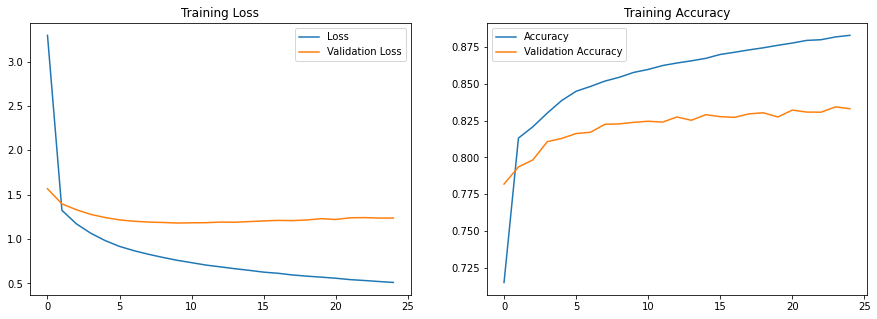

In [66]:
# visualizzazione andamento addestramento
# su un grafico composto da due sub-plot
# uno per il loss, l'altro per l'accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

# Errore durante l'addestramento
ax1.plot(history.history['loss'], label='Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Training Loss')
ax1.legend()

# Accuratezza durante l'addestramento
ax2.plot(history.history['accuracy'], label='Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title('Training Accuracy')
ax2.legend()

plt.show()

### Test del modello
La seguente cella permette di caricare l'ultimo checkpoint dell'addestramento
precedentemente salvato.

In [67]:
# Carico i pesi modello
latest = tf.train.latest_checkpoint(PATH_WEIGHTS)
transformer.load_weights(latest)

In [70]:
class Translate:
  def __init__(self, transformer_block, tokenizers, tokenizer_bert):
    self.transformer = transformer_block
    self.tokenizers = tokenizers
    self.tokenizer_bert = tokenizer_bert

  def predict(self, input_text, max_length):
    if input_text is None:
      input_text = input_data[np.random.choice(len(input_data))]
      print(input_text)

    # print(input_text)
    inputs_encoder = self.tokenizers.en.tokenize(input_text).to_tensor()
    inputs_encoder = keras.preprocessing.sequence.pad_sequences(inputs_encoder, maxlen=max_length, padding='post')
    inputs_bert = tokenizer_encoder(input_text)

    # print(inputs_encoder)
    
    start_end = self.tokenizers.it.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = (start_end[1][tf.newaxis]).numpy()[0]

    output_array = tf.TensorArray(dtype=tf.int64, size=max_length, dynamic_size=True)
    output_array = output_array.write(0, start)     

    out_words = []

    for i in tf.range(max_length):
      # decodifica e recupero probabilità di output
      output = tf.transpose(output_array.stack())
      # print('Output', output)
      transformer_output = transformer([inputs_bert, inputs_encoder, output], 
                                        training=False,
                                        debug=False)

      predictions = transformer_output[:, -1:, :]

      # selezione della parola più probabile
      predict = tf.argmax(predictions, -1)
      pred_values = (K.argmax(transformer_output, axis=-1)).numpy()
      # preds = pred_values[0][predict.numpy()[0][0]]
      
      # print('predict',  predict)
      # print('predictions', transformer_output)
      # print('pred_values', pred_values[0][0])
      # print('predict[0]', pred_values[0][i])
      
  
      # print('Preds', preds)
      # print('Detokenize', (tokenizers.it.detokenize(pred_values)))
      # print('##########################')
    
      # inserimento della parola nella sequenza di output
      output_array = output_array.write(i+1, [pred_values[0][i]])
      # output_array = output_array.write(i+1, predict[0])

      # termine del ciclo quando si incontra il token <end-of-sentence>
      # oppure la lunghezza massima prevista della sequenza
      # print(end)
      if pred_values[0][i] == end:
        break

    output = tf.transpose(output_array.stack())
    text = tokenizers.it.detokenize(output)[0]  

    tokens = tokenizers.it.lookup(output)[0]

    return text, tokens

In [71]:
test_sequences = ["Hi, my name is Daniele", "how are you", test_input_data[612], test_input_data[432], test_input_data[222]]

translate = Translate(transformer_block=transformer,
                      tokenizers=tokenizers,
                      tokenizer_bert=tokenizer_encoder)

for test_sequence in test_sequences:
  text, token = translate.predict(tf.constant([test_sequence]), MAX_SEQ_LENGTH)

  print(f'{"Input:":15s}: {test_sequence}')
  print(f'{"Prediction":15s}: {text.numpy().decode("utf-8")}')  
  # print(f'tokens : {token}')
  # print(target_data[41])
  # break
  print('---------------------------------------------')

print(test_target_data[41])
print(test_target_data[102])
print(test_target_data[612])
print(test_target_data[432])
print(test_target_data[222])

Input:         : Hi, my name is Daniele
Prediction     : io ho bisogno di un ' accordo .
---------------------------------------------
Input:         : how are you
Prediction     : loro sono un ' accordo ?
---------------------------------------------
Input:         : We all stood.
Prediction     : loro si e basta .
---------------------------------------------
Input:         : Tom will die.
Prediction     : tom ha bisogno di tom .
---------------------------------------------
Input:         : Tom is going.
Prediction     : tom e basta .
---------------------------------------------
Loro sono deboli.
Tom può leggere.
Eravamo tutte in piedi.
Tom morirà.
Tom sta andando.


### Tensorboard

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
log_dir

In [ ]:
%tensorboard --logdir drive/MyDrive/BERT/logs/fit/20221026-134720